<a href="https://colab.research.google.com/github/Anzay12/Prediction_RTO/blob/main/RTO_BDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ADVANCED CUSTOMER ANALYTICS - RTO PREDICTION WITH HYPERPARAMETER TUNING

1. Loading and preprocessing dataset...
Original dataset shape: (10999, 12)
Dataset shape after dropping ID: (10999, 11)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Warehouse_block      10999 non-null  object
 1   Mode_of_Shipment     10999 non-null  object
 2   Customer_care_calls  10999 non-null  int64 
 3   Customer_rating      10999 non-null  int64 
 4   Cost_of_the_Product  10999 non-null  int64 
 5   Prior_purchases      10999 non-null  int64 
 6   Product_importance   10999 non-null  object
 7   Gender               10999 non-null  object
 8   Discount_offered     10999 non-null  int64 
 9   Weight_in_gms        10999 non-null  int64 
 10  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 945

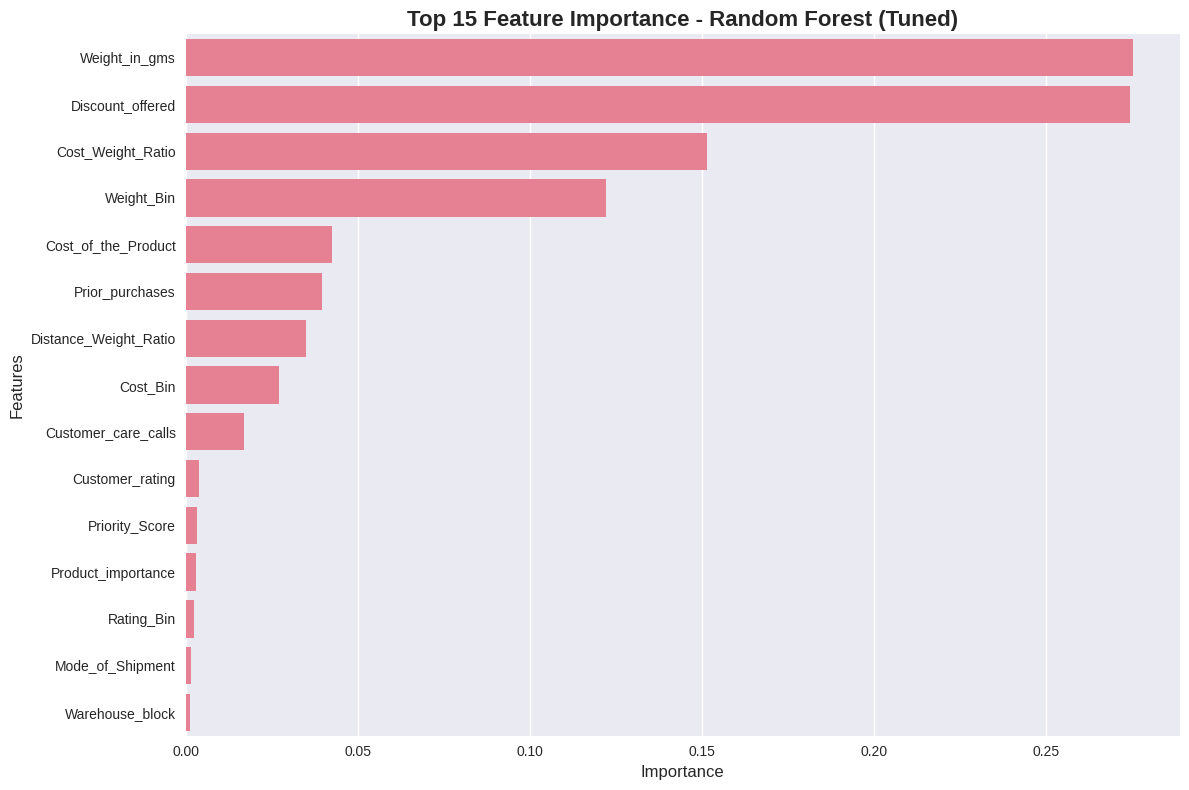


11. Creating Advanced Visualizations...


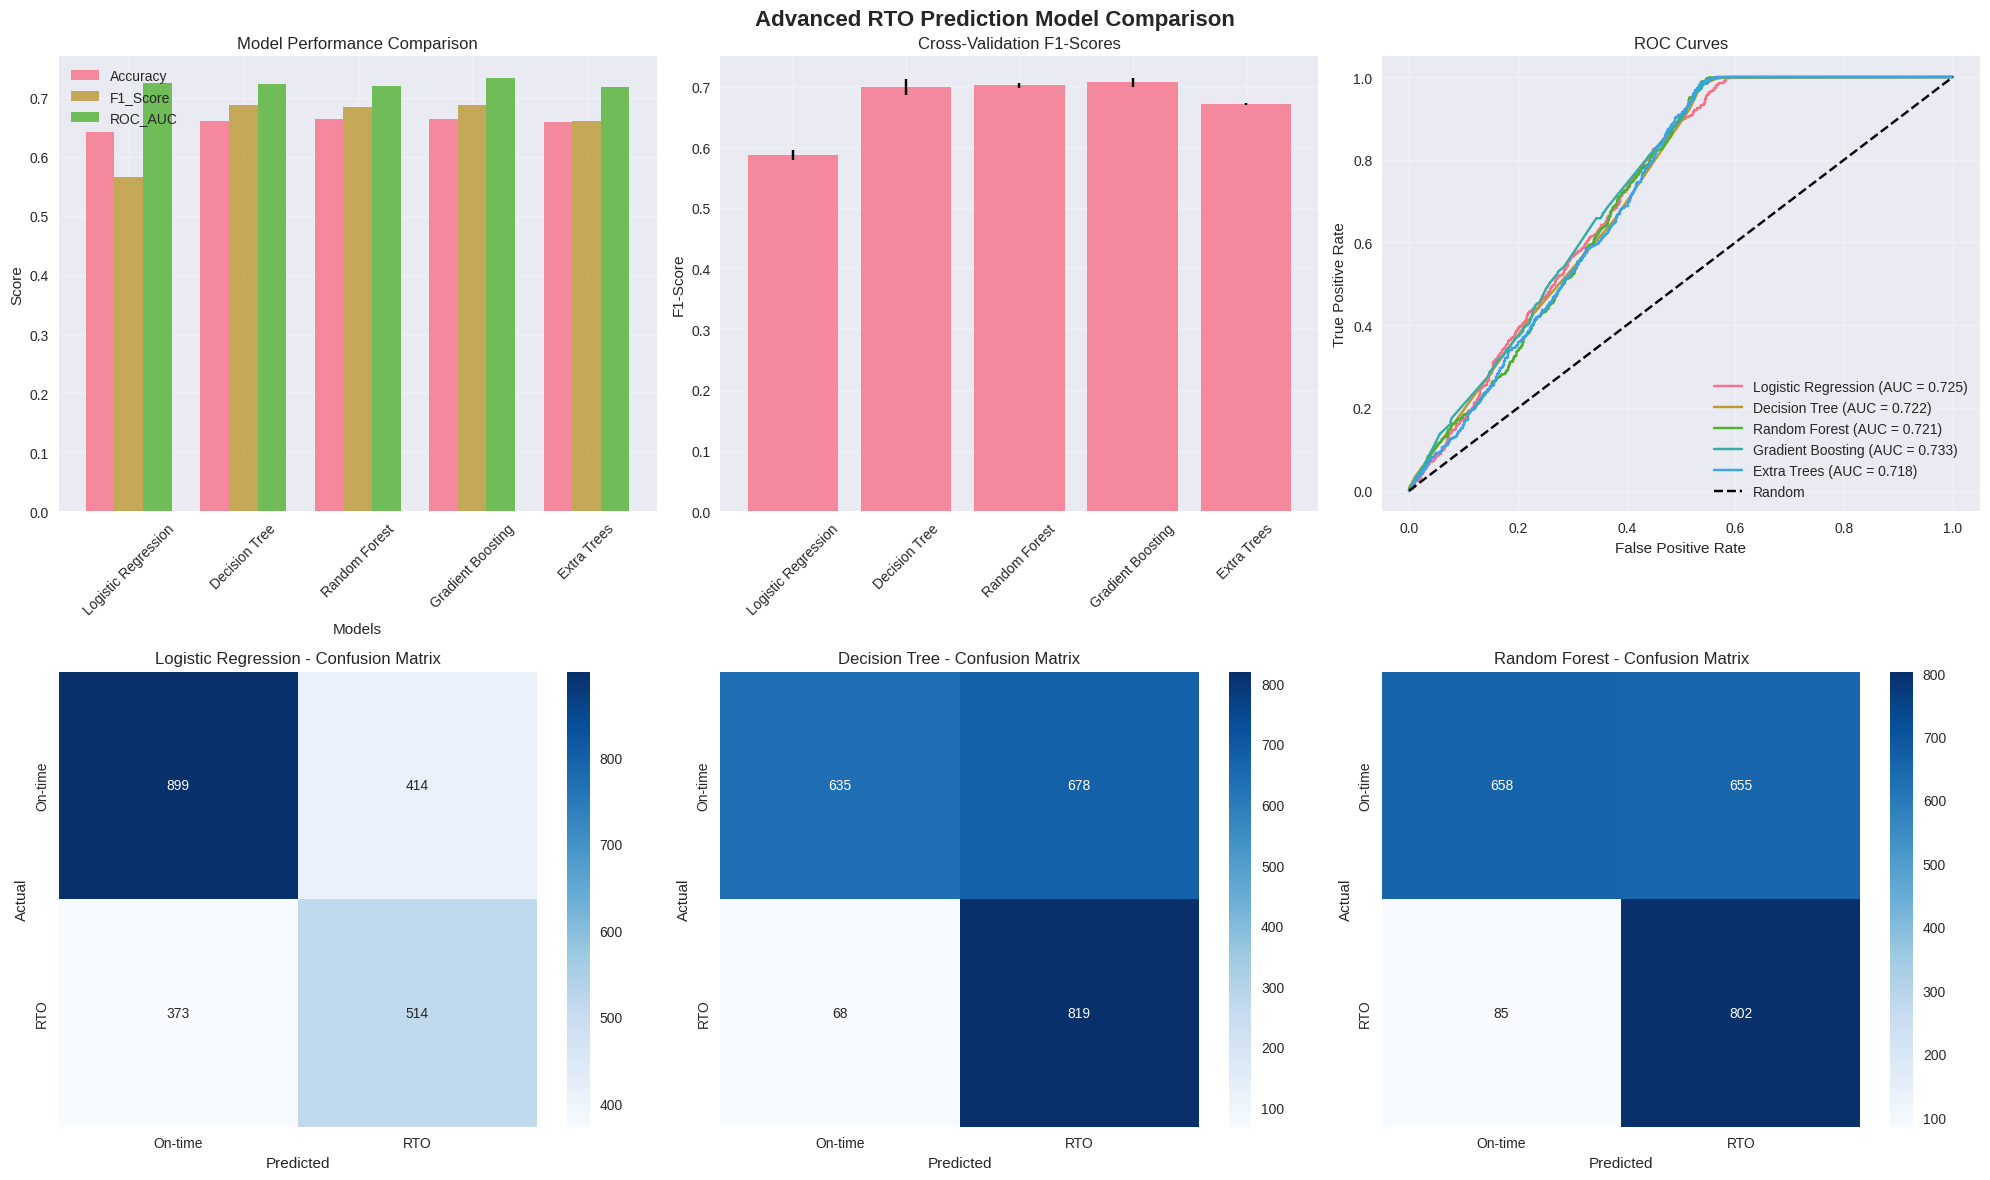


12. Precision-Recall Analysis...


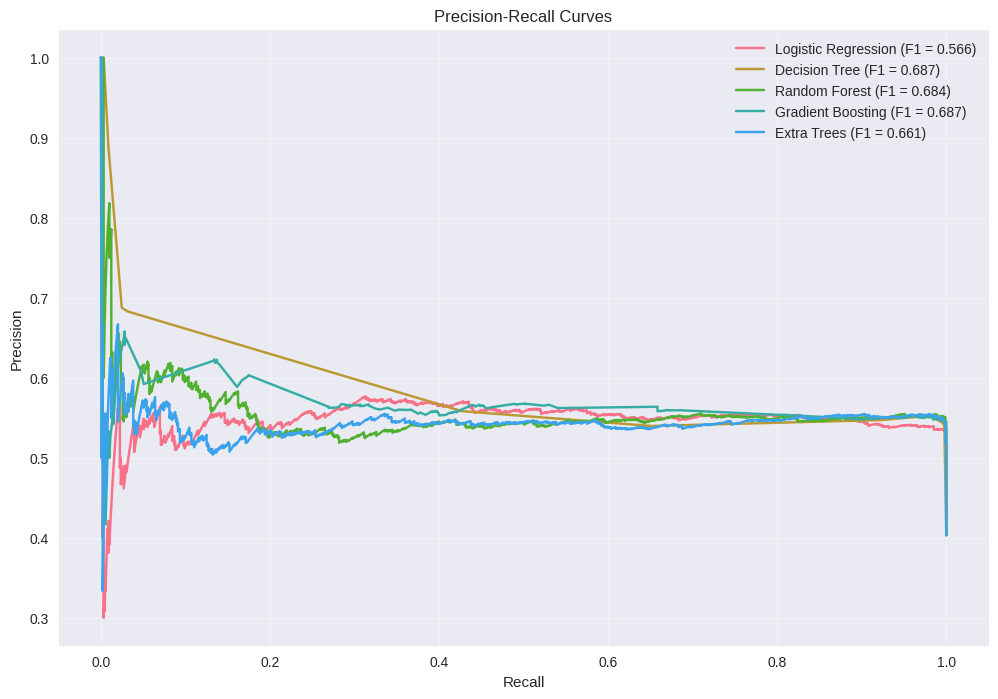


13. Model Comparison Heatmap...


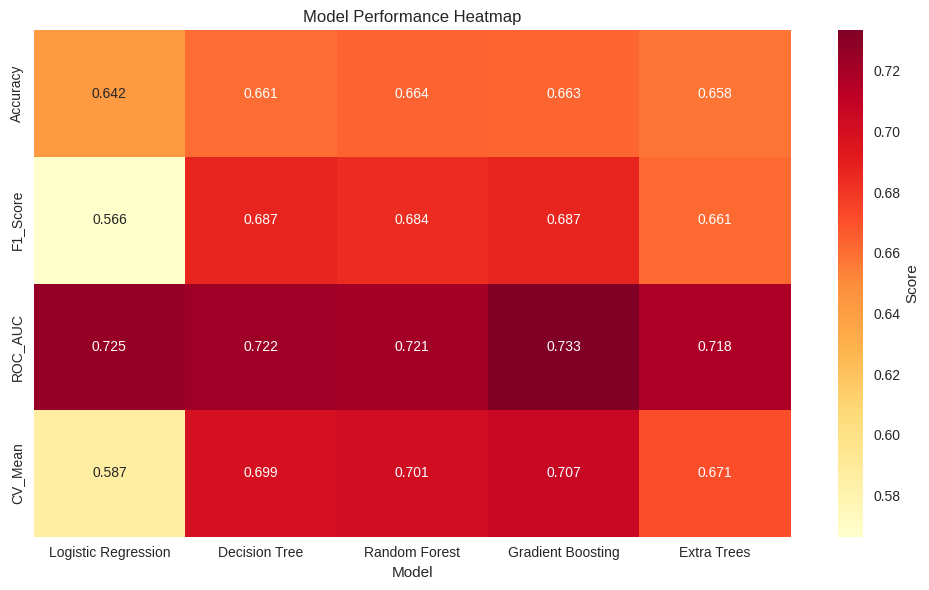


14. Saving Results...
Results saved successfully!

ADVANCED ANALYSIS COMPLETE!
 Files saved:
   - advanced_model_results.csv
   - best_hyperparameters.csv
   - advanced_feature_importance.csv

 Best Model Summary:
   Model: Gradient Boosting
   F1-Score: 0.6875
   Accuracy: 0.6632
   ROC-AUC: 0.7333
   CV F1-Score: 0.7066 (+/- 0.0142)

 Hyperparameter Tuning Results:
   Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
   Decision Tree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
   Random Forest: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
   Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
   Extra Trees: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

 Model Rankings:
   1. Gradient Boosting: F1=0.6875, AUC=0.7333
   2. Decision Tree: F1=0.6

In [ ]:


# ============================================================================
# CELL 1: Install Required Libraries
# ============================================================================

!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn plotly

# ============================================================================
# CELL 2: Import Libraries and Setup
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print('=' * 80)
print('ADVANCED CUSTOMER ANALYTICS - RTO PREDICTION WITH HYPERPARAMETER TUNING')
print('=' * 80)

# ============================================================================
# CELL 3: Load and Preprocess Dataset
# ============================================================================

# 1. Load the dataset and drop the 'ID' column
print('\n1. Loading and preprocessing dataset...')
df = pd.read_csv('Train.csv')
print(f'Original dataset shape: {df.shape}')

# Drop ID column
df = df.drop('ID', axis=1)
print(f'Dataset shape after dropping ID: {df.shape}')

# Display initial info
print('\nDataset Info:')
print(df.info())
print('\nFirst few rows:')
print(df.head())

# ============================================================================
# CELL 4: Handle Missing Values
# ============================================================================

# 2. Handle missing values if any
print('\n2. Checking for missing values...')
missing_values = df.isnull().sum()
print('Missing values per column:')
print(missing_values)
print(f'Total missing values: {missing_values.sum()}')

if missing_values.sum() > 0:
    print('Handling missing values...')
    # Fill missing values with appropriate strategies
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == 'object':
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                df[col].fillna(df[col].median(), inplace=True)
    print('Missing values handled successfully')

# ============================================================================
# CELL 5: Encode Categorical Variables
# ============================================================================

# 3. Encode categorical variables
print('\n3. Encoding categorical variables...')
categorical_columns = ['Warehouse_block', 'Mode_of_Shipment', 'Gender', 'Product_importance']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    print(f'Encoded {col}: {len(le.classes_)} categories')

# ============================================================================
# CELL 6: Create RTO Column
# ============================================================================

# 4. Create a new binary column 'RTO' where 'Reached.on.Time_Y.N' == 0
print('\n4. Creating RTO binary column...')
df['RTO'] = (df['Reached.on.Time_Y.N'] == 0).astype(int)
print('RTO column created successfully')

# Display target distribution
rto_counts = df['RTO'].value_counts()
print(f'RTO Distribution:')
print(f'RTO (1): {rto_counts[1]} ({rto_counts[1]/len(df)*100:.1f}%)')
print(f'On-time (0): {rto_counts[0]} ({rto_counts[0]/len(df)*100:.1f}%)')

# ============================================================================
# CELL 7: Feature Engineering
# ============================================================================

# 5. Feature Engineering
print('\n5. Feature Engineering...')

# Create interaction features
df['Cost_Weight_Ratio'] = df['Cost_of_the_Product'] / (df['Weight_in_gms'] + 1)
df['Distance_Weight_Ratio'] = df['Customer_rating'] * df['Weight_in_gms']
df['Priority_Score'] = df['Product_importance'] * df['Customer_rating']

# Create bins for numerical features
df['Cost_Bin'] = pd.cut(df['Cost_of_the_Product'], bins=5, labels=[1,2,3,4,5])
df['Weight_Bin'] = pd.cut(df['Weight_in_gms'], bins=5, labels=[1,2,3,4,5])
df['Rating_Bin'] = pd.cut(df['Customer_rating'], bins=3, labels=[1,2,3])

# Convert bins to numeric
df['Cost_Bin'] = df['Cost_Bin'].astype(int)
df['Weight_Bin'] = df['Weight_Bin'].astype(int)
df['Rating_Bin'] = df['Rating_Bin'].astype(int)

print('Feature engineering completed:')
print('- Cost_Weight_Ratio')
print('- Distance_Weight_Ratio')
print('- Priority_Score')
print('- Cost_Bin, Weight_Bin, Rating_Bin')

# ============================================================================
# CELL 8: Data Splitting and Feature Selection
# ============================================================================

# 6. Split the dataset into train and test sets (80/20)
print('\n6. Splitting dataset into train/test sets...')
X = df.drop(['Reached.on.Time_Y.N', 'RTO'], axis=1)
y = df['RTO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

# 7. Feature Selection
print('\n7. Feature Selection...')

# Select top features using SelectKBest
selector = SelectKBest(score_func=f_classif, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = X.columns[selector.get_support()]
print(f'Selected {len(selected_features)} features:')
print(list(selected_features))

# ============================================================================
# CELL 9: Model Training with Hyperparameter Tuning
# ============================================================================

# 8. Advanced Model Training with Hyperparameter Tuning
print('\n8. Advanced Model Training with Hyperparameter Tuning...')

# Define models with hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=2000),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'Extra Trees': {
        'model': ExtraTreesClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    }
}

# Train and tune models
results = {}
best_models = {}

for name, model_info in models.items():
    print(f'\nTraining and tuning {name}...')

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )

    # Fit on selected features
    grid_search.fit(X_train_selected, y_train)

    # Get best model
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    # Make predictions
    y_pred = best_model.predict(X_test_selected)
    y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Cross-validation score
    cv_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='f1')

    results[name] = {
        'model': best_model,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'best_params': grid_search.best_params_
    }

    print(f'  {name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}')
    print(f'  CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})')
    print(f'  Best Parameters: {grid_search.best_params_}')

# ============================================================================
# CELL 10: Model Evaluation and Results
# ============================================================================

# 9. Detailed Model Evaluation
print('\n9. Detailed Model Evaluation')
print('=' * 80)

# Create comprehensive results DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'F1_Score': [results[name]['f1_score'] for name in results.keys()],
    'ROC_AUC': [results[name]['roc_auc'] for name in results.keys()],
    'CV_Mean': [results[name]['cv_mean'] for name in results.keys()],
    'CV_Std': [results[name]['cv_std'] for name in results.keys()]
})

print('\nModel Performance Summary:')
print(results_df.sort_values('F1_Score', ascending=False))

# Find best model
best_model_name = results_df.loc[results_df['F1_Score'].idxmax(), 'Model']
best_model = best_models[best_model_name]

print(f'\n🏆 Best Model: {best_model_name}')
print(f'F1-Score: {results[best_model_name]["f1_score"]:.4f}')
print(f'Accuracy: {results[best_model_name]["accuracy"]:.4f}')
print(f'ROC-AUC: {results[best_model_name]["roc_auc"]:.4f}')

# ============================================================================
# CELL 11: Feature Importance Analysis
# ============================================================================

# 10. Feature Importance Analysis
print('\n10. Feature Importance Analysis')
print('=' * 80)

# Get feature importance for tree-based models
importance_data = {}
for name in ['Random Forest', 'Gradient Boosting', 'Extra Trees']:
    if name in best_models:
        model = best_models[name]
        importance = model.feature_importances_
        importance_data[name] = pd.DataFrame({
            'feature': selected_features,
            'importance': importance
        }).sort_values('importance', ascending=False)

# Plot feature importance for best tree-based model
if 'Random Forest' in importance_data:
    rf_importance = importance_data['Random Forest']
    print('\nTop 15 Most Important Features (Random Forest):')
    print(rf_importance.head(15))

    plt.figure(figsize=(12, 8))
    top_features = rf_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title('Top 15 Feature Importance - Random Forest (Tuned)', fontsize=16, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

# ============================================================================
# CELL 12: Advanced Visualizations - Model Comparison
# ============================================================================

# 11. Advanced Visualizations
print('\n11. Creating Advanced Visualizations...')

# Model Performance Comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Advanced RTO Prediction Model Comparison', fontsize=16, fontweight='bold')

# Performance metrics comparison
ax1 = axes[0, 0]
model_names = list(results.keys())
metrics = ['Accuracy', 'F1_Score', 'ROC_AUC']
x = np.arange(len(model_names))
width = 0.25

for i, metric in enumerate(metrics):
    if metric == 'F1_Score':
        values = [results[name]['f1_score'] for name in model_names]
    elif metric == 'ROC_AUC':
        values = [results[name]['roc_auc'] for name in model_names]
    else:
        values = [results[name]['accuracy'] for name in model_names]
    ax1.bar(x + i * width, values, width, label=metric, alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x + width)
ax1.set_xticklabels(model_names, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cross-validation scores
ax2 = axes[0, 1]
cv_means = [results[name]['cv_mean'] for name in model_names]
cv_stds = [results[name]['cv_std'] for name in model_names]

ax2.bar(model_names, cv_means, yerr=cv_stds, capsize=5, alpha=0.8)
ax2.set_title('Cross-Validation F1-Scores')
ax2.set_ylabel('F1-Score')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# ROC Curves
ax3 = axes[0, 2]
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    ax3.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.3f})')

ax3.plot([0, 1], [0, 1], 'k--', label='Random')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Confusion Matrices
for i, (name, result) in enumerate(results.items()):
    if i < 3:
        ax = axes[1, i]
        cm = confusion_matrix(y_test, result['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['On-time', 'RTO'],
                    yticklabels=['On-time', 'RTO'],
                    ax=ax)
        ax.set_title(f'{name} - Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ============================================================================
# CELL 13: Precision-Recall Curves
# ============================================================================

# 12. Precision-Recall Curves
print('\n12. Precision-Recall Analysis...')
plt.figure(figsize=(12, 8))
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    plt.plot(recall, precision, label=f'{name} (F1 = {result["f1_score"]:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ============================================================================
# CELL 14: Model Comparison Heatmap
# ============================================================================

# 13. Model Comparison Heatmap
print('\n13. Model Comparison Heatmap...')
comparison_data = results_df.set_index('Model')[['Accuracy', 'F1_Score', 'ROC_AUC', 'CV_Mean']]

plt.figure(figsize=(10, 6))
sns.heatmap(comparison_data.T, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Score'})
plt.title('Model Performance Heatmap')
plt.tight_layout()
plt.show()

# ============================================================================
# CELL 15: Save Results
# ============================================================================

# 14. Save Results
print('\n14. Saving Results...')

# Save detailed results
results_df.to_csv('advanced_model_results.csv', index=False)

# Save best parameters
best_params_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Best_Parameters': [str(results[name]['best_params']) for name in results.keys()]
})
best_params_df.to_csv('best_hyperparameters.csv', index=False)

# Save feature importance
if 'Random Forest' in importance_data:
    importance_data['Random Forest'].to_csv('advanced_feature_importance.csv', index=False)

print('Results saved successfully!')

# ============================================================================
# CELL 16: Final Summary
# ============================================================================

# 15. Final Summary
print('\n' + '=' * 80)
print('ADVANCED ANALYSIS COMPLETE!')
print('=' * 80)
print(' Files saved:')
print('   - advanced_model_results.csv')
print('   - best_hyperparameters.csv')
print('   - advanced_feature_importance.csv')

print('\n Best Model Summary:')
print(f'   Model: {best_model_name}')
print(f'   F1-Score: {results[best_model_name]["f1_score"]:.4f}')
print(f'   Accuracy: {results[best_model_name]["accuracy"]:.4f}')
print(f'   ROC-AUC: {results[best_model_name]["roc_auc"]:.4f}')
print(f'   CV F1-Score: {results[best_model_name]["cv_mean"]:.4f} (+/- {results[best_model_name]["cv_std"] * 2:.4f})')

print('\n Hyperparameter Tuning Results:')
for name, result in results.items():
    print(f'   {name}: {result["best_params"]}')

print('\n Model Rankings:')
ranked_models = results_df.sort_values('F1_Score', ascending=False)
for i, (_, row) in enumerate(ranked_models.iterrows(), 1):
    print(f'   {i}. {row["Model"]}: F1={row["F1_Score"]:.4f}, AUC={row["ROC_AUC"]:.4f}')

print('=' * 80)